In [1]:
import os
import sys
import math
import logging
import yaml
import h5py
from pathlib import Path

import kerastuner as kt

import numpy as np
import scipy as sp
import tensorflow as tf

%load_ext autoreload
%autoreload 2

import matplotlib as mpl
mpl.use('Qt5Agg')
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set_context("poster")
sns.set(rc={'figure.figsize': (16, 9.)})
sns.set_style("whitegrid")

import pandas as pd
pd.set_option("display.max_rows", 120)
pd.set_option("display.max_columns", 120)

import began
from began.logging import setup_vae_run_logging
from began.vae import inception_module
from began.visualization import mplot

from tensorflow.keras.layers import Conv2D, UpSampling2D, Conv2DTranspose
from tensorflow.keras.layers import BatchNormalization, MaxPooling2D, Concatenate, Dense, Reshape, Input
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.models import Model

logging.basicConfig(level=logging.INFO, stream=sys.stdout)

In [2]:
# function for creating a naive inception block
def inception_module(layer_in, f1, f2, f3):
    """ An implementation of the Inception module.
    """
    # 1x1 conv
    conv1 = Conv2D(f1, (1,1), padding='same', activation='relu')(layer_in)
    # 3x3 conv
    conv3 = Conv2D(f2, (3,3), padding='same', activation='relu')(layer_in)
    # 5x5 conv
    conv5 = Conv2D(f3, (5,5), padding='same', activation='relu')(layer_in)
    # 3x3 max pooling
    pool = MaxPooling2D((3,3), strides=(1,1), padding='same')(layer_in)
    # concatenate filters, assumes filters/channels last
    layer_out = Concatenate(axis=-1)([conv1, conv3, conv5, pool])
    return layer_out

# function for creating a naive inception block
def transpose_inception_module(layer_in, f1, f2, f3):
    """ An implementation of the Inception module.
    """
    # 1x1 conv
    conv1 = Conv2DTranspose(f1, kernel_size=1, strides=(2, 2), padding='same', activation='relu')(layer_in)
    # 3x3 conv
    conv3 = Conv2DTranspose(f2, kernel_size=1, strides=(2, 2), padding='same', activation='relu')(layer_in)
    # 5x5 conv
    conv5 = Conv2DTranspose(f3, kernel_size=1, strides=(2, 2), padding='same', activation='relu')(layer_in)
    # 3x3 max pooling
    upsamp = UpSampling2D((2, 2), interpolation='nearest')(layer_in)
    pool = MaxPooling2D((3,3), strides=(1,1), padding='same')(upsamp)
    # concatenate filters, assumes filters/channels last
    layer_out = Concatenate(axis=-1)([conv1, conv3, conv5, pool])
    return layer_out

In [3]:
lat_dim = 128
latz = Input((lat_dim,))

dlr0 = Dense(units=(16 * 16 * 32), activation=tf.nn.relu)(latz)
res0 = Reshape(target_shape=(16, 16, 32))(dlr0)
assert res0.shape.as_list() == [None, 16, 16, 32]

btn0 = BatchNormalization(momentum=0.9)(res0)
cvt0 = Conv2DTranspose(filters=128, kernel_size=5, strides=(2, 2), padding="SAME", activation='relu')(btn0)
assert cvt0.shape.as_list() == [None, 32, 32, 128]

btn1 = BatchNormalization(momentum=0.9)(cvt0)
cvt1 = Conv2DTranspose(filters=128, kernel_size=5, strides=(2, 2), padding="SAME", activation='relu')(btn1)
assert cvt1.shape.as_list() == [None, 64, 64, 128]

btn2 = BatchNormalization(momentum=0.9)(cvt1)
cvt2 = Conv2DTranspose(filters=128, kernel_size=5, strides=(2, 2), padding="SAME", activation='relu')(btn2)
assert cvt2.shape.as_list() == [None, 128, 128, 128]

btn3 = BatchNormalization(momentum=0.9)(cvt2)
cvt3 = Conv2DTranspose(filters=128, kernel_size=5, strides=(2, 2), padding="SAME", activation='relu')(btn3)
assert cvt3.shape.as_list() == [None, 256, 256, 128]

cvt4 = Conv2DTranspose(filters=1, kernel_size=5, strides=(1, 1), padding="SAME")(cvt3)

model = Model([latz], cvt4)

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128)]             0         
_________________________________________________________________
dense (Dense)                (None, 8192)              1056768   
_________________________________________________________________
reshape (Reshape)            (None, 16, 16, 32)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 16, 16, 32)        128       
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 32, 32, 128)       102528    
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 128)       512       
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 64, 64, 128)       409728

In [4]:
def decoder(lat_dim=128):
    lat_dim = 128
    latz = Input((lat_dim,))

    dlr0 = Dense(units=(16 * 16 * 32), activation=tf.nn.relu)(latz)
    res0 = Reshape(target_shape=(16, 16, 32))(dlr0)
    assert res0.shape.as_list() == [None, 16, 16, 32]

    btn0 = BatchNormalization(momentum=0.9)(res0)
    icp0 = inception_module(btn0, 32, 128, 64)
    ups0 = UpSampling2D((2, 2), interpolation='nearest')(icp0)
    assert ups0.shape.as_list() == [None, 32, 32, 256]

    btn1 = BatchNormalization(momentum=0.9)(ups0)
    icp1 = inception_module(btn1, 32, 128, 64)
    ups1 = UpSampling2D((2, 2), interpolation='nearest')(icp1)
    assert ups1.shape.as_list() == [None, 64, 64, 480]

    btn2 = BatchNormalization(momentum=0.9)(ups1)
    icp2 = inception_module(btn2, 32, 128, 64)
    ups2 = UpSampling2D((2, 2), interpolation='nearest')(icp2)
    assert ups2.shape.as_list() == [None, 128, 128, 704]

    btn3 = BatchNormalization(momentum=0.9)(ups2)
    icp3 = inception_module(btn3, 32, 128, 64)
    ups3 = UpSampling2D((2, 2), interpolation='nearest')(icp3)
    assert ups3.shape.as_list() == [None, 256, 256, 928]

    avg0 = Conv2D(1, (1, 1), padding='same', activation='relu')(ups3)
    assert avg0.shape.as_list() == [None, 256, 256, 1]

    model = Model([latz], avg0, name="Decoder")
    return model

def transpose_decoder(lat_dim=128):
    lat_dim = 128
    latz = Input((lat_dim,))

    dlr0 = Dense(units=(16 * 16 * 32), activation=tf.nn.relu)(latz)
    res0 = Reshape(target_shape=(16, 16, 32))(dlr0)
    assert res0.shape.as_list() == [None, 16, 16, 32]

    btn0 = BatchNormalization(momentum=0.9)(res0)
    icp0 = transpose_inception_module(btn0, 32, 128, 64)
    assert icp0.shape.as_list() == [None, 32, 32, 256]

    btn1 = BatchNormalization(momentum=0.9)(icp0)
    icp1 = transpose_inception_module(btn1, 32, 128, 64)
    assert icp1.shape.as_list() == [None, 64, 64, 480]

    btn2 = BatchNormalization(momentum=0.9)(icp1)
    icp2 = transpose_inception_module(btn2, 32, 128, 64)
    assert icp2.shape.as_list() == [None, 128, 128, 704]

    btn3 = BatchNormalization(momentum=0.9)(icp2)
    icp3 = transpose_inception_module(btn3, 32, 128, 64)
    assert icp3.shape.as_list() == [None, 256, 256, 928]

    avg0 = Conv2D(1, (1, 1), padding='same', activation='relu')(icp3)
    assert avg0.shape.as_list() == [None, 256, 256, 1]

    model = Model([latz], avg0, name="Decoder")
    return model

def make_vae_inference_net(latent_dim):
    model = tf.keras.Sequential(name='Encoder')
    
    model.add(tf.keras.layers.InputLayer(input_shape=(256, 256, 1)))
    model.add(tf.keras.layers.Conv2D(filters=256, kernel_size=5, padding="SAME", strides=(2, 2), activation='relu'))
    assert model.output_shape == (None, 128, 128, 256)
    
    model.add(tf.keras.layers.Conv2D(filters=128, kernel_size=3, padding="SAME", strides=(2, 2), activation='relu'))
    assert model.output_shape == (None, 64, 64, 128)
    
    model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=1, padding="SAME", strides=(2, 2), activation='relu'))
    assert model.output_shape == (None, 32, 32, 64)
    
    model.add(tf.keras.layers.Flatten())
    assert model.output_shape == (None, 32 * 32 * 64)
    
    model.add(tf.keras.layers.Dense(latent_dim + latent_dim))
    return model

In [5]:
class CVAE(tf.keras.Model):
    def __init__(self, latent_dim, kernel_size):
        super(CVAE, self).__init__()
        self.latent_dim = latent_dim
        self.inference_net = make_vae_inference_net(latent_dim)
        self.generative_net = transpose_decoder(latent_dim)

    @tf.function
    def sample(self, eps=None):
        if eps is None:
            eps = tf.random.normal(shape=(100, self.latent_dim))
        return self.decode(eps, apply_sigmoid=True)

    def encode(self, x):
        mean, logvar = tf.split(self.inference_net(x), num_or_size_splits=2, axis=1)
        return mean, logvar

    def reparameterize(self, mean, logvar):
        eps = tf.random.normal(shape=mean.shape)
        return eps * tf.exp(logvar * .5) + mean

    def decode(self, z, apply_sigmoid=False):
        logits = self.generative_net(z)
        if apply_sigmoid:
            probs = tf.sigmoid(logits)
            return probs
        return logits

    
def compute_apply_gradients(model, x, optimizer):
    with tf.GradientTape() as tape:
        loss = began.vae.compute_loss(model, x)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

def generate_and_save_images(model, epoch, test_input, plot_dir, title=None):
    predictions = model.sample(test_input)
    mean = np.mean(predictions)
    std = np.std(predictions)
    fig, _ = mplot(predictions[..., 0], extent=(-10, 10, -10, 10), title=title, cbar_range=[mean - 2*std, mean+2*std])
    fig.savefig(plot_dir / 'image_at_epoch_{:04d}.png'.format(epoch))
    plt.close('all')


In [6]:
model = CVAE(128, 5)
summary_writer = setup_vae_run_logging(128, 8, 10)

In [7]:
with h5py.File("../data/preprocessed/prepared.h5", 'r') as f:
    dset = f["cut_maps"]
    train_images = dset[...].astype(np.float32)

dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(train_images.shape[0]).batch(8).map(tf.image.per_image_standardization)
test_dataset = dataset.take(100)
train_dataset = dataset.skip(100)

Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
ERROR:tornado.application:Exception in callback functools.partial(<function Kernel.enter_eventloop.<locals>.advance_eventloop at 0x2aebd545f680>)
Traceback (most recent call last):
  File "/home/bthorne/projects/gan/began/envs-gpu/lib/python3.7/site-packages/tornado/ioloop.py", line 743, in _run_callback
    ret = callback()
  File "/home/bthorne/projects/gan/began/envs-gpu/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 310, in advance_eventloop
    eventloop(self)
TypeError: 'NoneType' object is not callable


In [8]:
optimizer = tf.keras.optimizers.Adam(beta_1=0.5, learning_rate=0.0002)
random_vector_for_generation = tf.random.normal(shape=[9, 128])
for epoch in range(1, 10):
    print("Epoch: ", epoch)

    for step, train_x in enumerate(train_dataset):
        compute_apply_gradients(model, train_x, optimizer)

    if epoch % 1 == 0:
        loss = tf.keras.metrics.Mean()
        for test_x in test_dataset:
            loss(began.vae.compute_loss(model, test_x))
        elbo = -loss.result()
        print("\t loss: ", elbo)

        with summary_writer.as_default():
            tf.summary.scalar('elbo', elbo, step=epoch)
        title = 'Epoch: {:03d}, Test set ELBO: {:04.02f}'.format(epoch, elbo)
        generate_and_save_images(model, epoch, random_vector_for_generation, Path("./plots").absolute(), title)

Epoch:  1


ResourceExhaustedError:  OOM when allocating tensor with shape[8,928,256,256] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[node gradients/Decoder/conv2d_3/Conv2D_grad/Conv2DBackpropInput (defined at /home/bthorne/projects/gan/began/envs-gpu/lib/python3.7/site-packages/tensorflow_core/python/framework/ops.py:1751) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.
 [Op:__inference___backward_compute_loss_2705_3297]

Function call stack:
__backward_compute_loss_2705


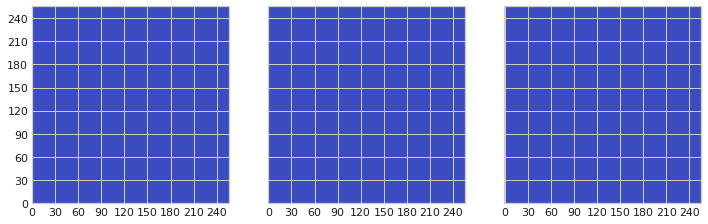

In [57]:
mplot(model.decode(np.random.randn(3, 128))[..., 0]);